<a href="https://colab.research.google.com/github/mgopal64/SoilMoisturePrediction/blob/main/GelmanPlumePINNPresentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case-Study: Physics-Informed Neural Network to model Gelman Dioxane Plume in Ann Arbor, MI

# Model Card: Gelman 1,4-Dioxane PINN (130-170ft Unit)

This Model Card provides a professional summary of the Physics-Informed Neural Network (PINN) developed to forecast the migration of 1,4-Dioxane at the Gelman Sciences site in Ann Arbor, MI.

---

## 1. Model Details

- **Model Type:** Physics-Informed Neural Network (PINN)
- **Architecture:** Deep Neural Network (4 hidden layers, 64 neurons each) using Tanh activation functions for smooth second-order derivatives
- **Physics Constraint:** 1D Advection-Dispersion Equation (ADE):

$$\frac{\partial C}{\partial t} + v \frac{\partial C}{\partial x} - D \frac{\partial^2 C}{\partial x^2} = 0$$

- **Optimization Strategy:** Dual-stage approach using Adam (10,000 epochs) for global search followed by L-BFGS refinement for high-precision physical convergence
- **Version:** 1.0 (Deep Unit Analysis)

---

## 2. Intended Use

- **Primary Purpose:** Long-term spatiotemporal forecasting of the 1,4-Dioxane plume front
- **Scope:** Specifically isolated to the 130-170 ft depth band, representing the high-conductivity basal aquifer unit
- **Target Domain:** Spatial extrapolation across "data deserts"—specifically the 9,000 ft gap between the easternmost monitoring wells and the Huron River/Barton Pond boundary

---

## 3. Training & Validation Data

- **Source:** ArcGIS-hosted historical monitoring data (Washtenaw County / Gelman Sciences)
- **Temporal Range:** January 1986 – January 2026
- **Spatial Range:** 0 to 18,178 ft (Gelman Source to Barton Pond)
- **Input Features:** Normalized distance along transect ($x$), Normalized time ($t$)
- **Label:** Log-normalized 1,4-Dioxane concentration ($C_{norm}$)

---

## 4. Performance Metrics

The model was validated using Leave-One-Well-Out (LOWO) cross-validation to ensure that the physics constraints enforced generalization rather than spatial overfitting.

| Metric | Value | Interpretation |
|--------|-------|----------------|
| Data $R^2$ Score | 0.88 | High fidelity to historical well data trends |
| Normalized RMSE | 0.0476 | Consistent error across log-scale features |
| Physical RMSE | ±0.79 ppb | Average precision relative to Michigan's 7.2 ppb safety limit |
| Mean Physics Residual | 2.74e-04 | Strict adhers to the laws of fluid dynamics |

---

## 5. Key Findings & Predictions

- **Year of Impact:** Predictions indicate the 7.2 ppb front will not impact the Barton Pond boundary within a 100-year horizon for this depth unit
- **Hydraulic Insights:** The model successfully "learned" site-specific velocity ($v$) and dispersion ($D$) coefficients that align with established hydrogeological literature for the area
- **Regulatory Status:** Predicted 2056 concentrations at the river boundary remain significantly below the Michigan Safe Drinking Water standard

---

## 6. Limitations & Risk

- **Dimensionality:** This is a 1D transect model; it does not account for lateral plume spreading outside the 2,000 ft analysis buffer
- **Vertical Migration:** The model assumes no significant vertical leakage between units (e.g., to the shallower 50-90 ft band)
- **Source Term:** Assumes a continuous boundary condition at the source based on historical log-maximums

---

## 7. Developer Metadata

- **Developer:** Manush Gopal
- **Framework:** PyTorch (Pure Implementation)
- **Date:** January 2026

#1) Setup & Data Ingestion

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from pyproj import Transformer
from sklearn.metrics import mean_squared_error, r2_score
!pip install arcgis pyproj -q

os.environ["DDE_BACKEND"] = "pytorch"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.5/738.5 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 4.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.4.1 which is incompatible.
prophet 1.2.2 requires numpy<2.4.0,>=1.15.4, but you have numpy 2.4.1 which is incompatible.
rapids-dask-dependency 25.10.0 requires das

In [2]:
# Constants for Normalization, Mapping, and Transect
T_START_DATE = pd.Timestamp('1986-01-01')
T_MAX_YEARS = 70.0  # Horizon 1986 - 2056, predicts up to 2056
X_MAX_DIST = 18178.0 # Distance to Barton Pond from Gelman Source
C_LOG_MAX = np.log10(212000 + 1)

# Note: using Michigan State plane coordinate system!
source_coord = np.array([13278097, 279314])
target_coord = np.array([13286705, 298215])

def distance_to_line(points, line_start, line_end):
    line_vec = line_end - line_start
    line_len = np.linalg.norm(line_vec)
    line_unit = line_vec / line_len
    point_vec = points - line_start
    proj_length = np.dot(point_vec, line_unit)
    proj_point = line_start + np.outer(proj_length, line_unit)
    perp_dist = np.linalg.norm(points - proj_point, axis=1)
    return perp_dist, proj_length

# 2) Model Architecture (PINN Class)

In [3]:
class DioxanePINN(nn.Module):
    def __init__(self):
        super(DioxanePINN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1), nn.Sigmoid()
        )
        # v = velocity and D = dispersion are learnable parameters
        self.v_raw = nn.Parameter(torch.tensor([0.0], requires_grad=True))
        self.D_raw = nn.Parameter(torch.tensor([0.0], requires_grad=True))

    def forward(self, x, t):
        return self.network(torch.cat([x, t], dim=1))

    def get_physics_params(self):
        # Bounding v (0.1-5.0 ft/d) and D (1.0-100.0 ft²/d) based on available site hydrologic literature
        v = 0.1 + (5.0 - 0.1) * torch.sigmoid(self.v_raw)
        D = 1.0 + (100.0 - 1.0) * torch.sigmoid(self.D_raw)
        return v, D

In [4]:
# Function calculates loss from Advection-Dispersion Equation (from environmental engineering)
def compute_physics_loss(model, x, t):
    v_day, D_day = model.get_physics_params()
    v, D = v_day * 365.25, D_day * 365.25 # Scale to years


    # Below are the derivatives seen in the Advection-Dispersion Equation
    C = model(x, t)
    C_t = torch.autograd.grad(C, t, torch.ones_like(C), create_graph=True)[0] / T_MAX_YEARS
    C_x = torch.autograd.grad(C, x, torch.ones_like(C), create_graph=True)[0] / X_MAX_DIST
    C_xx = torch.autograd.grad(C_x, x, torch.ones_like(C_x), create_graph=True)[0] / (X_MAX_DIST**2)

    residual = C_t + v*C_x - D*C_xx
    return torch.mean(residual**2)

# 3: Training & Optimization

In [5]:
from google.colab import drive
import os

drive.mount('/content/drive')

# Ensure path is exact. If you didn't save with .pth, keep it as is.
WEIGHTS_PATH = '/content/drive/MyDrive/gelman-pinn/model_130_170ftploss5'

# 1. Load data & Transect calculation
df = pd.read_pickle('/content/drive/MyDrive/gelman-pinn/merged_df.pkl')
wells = df.groupby('Bore').agg({'Easting': 'first', 'Northing': 'first'}).reset_index()
well_coords = wells[['Easting', 'Northing']].values.astype(float)
perp_dist, along_dist = distance_to_line(well_coords, source_coord, target_coord)
wells['perp_dist_ft'], wells['along_dist_ft'] = perp_dist, along_dist
df = df.merge(wells[['Bore', 'perp_dist_ft', 'along_dist_ft']], on='Bore')

# 2. Filtering for 130-170ft Band
pinn_df = df[(df['TotalDepth'] >= 130) & (df['TotalDepth'] <= 170) &
             (df['perp_dist_ft'].abs() <= 1000) & (df['along_dist_ft'] >= -100) & (df['Value'] > 0.5)].copy()

pinn_df.dropna(subset=['along_dist_ft', 'Value'], inplace=True)
pinn_df['SampleDate'] = pd.to_datetime(pinn_df['SampleDate'])
pinn_df['t_years'] = (pinn_df['SampleDate'] - T_START_DATE).dt.days / 365.25
pinn_df['C_norm'] = np.log10(pinn_df['Value'] + 1) / C_LOG_MAX
pinn_df['t_norm'] = pinn_df['t_years'] / T_MAX_YEARS
pinn_df['x_norm'] = pinn_df['along_dist_ft'] / X_MAX_DIST

# 3. Load Model
model = DioxanePINN().to(device)

if os.path.exists(WEIGHTS_PATH):
    model.load_state_dict(torch.load(WEIGHTS_PATH, map_location=device))
    model.eval()
    print(f"✅ Success: Pre-trained weights loaded from {WEIGHTS_PATH}")

    # Final Physics Extraction from the weights
    v_final, D_final = model.get_physics_params()
    print(f"=== CALIBRATED HYDRAULIC PARAMETERS ===")
    print(f"Learned Velocity (v):   {v_final.item():.4f} ft/day")
    print(f"Learned Dispersion (D): {D_final.item():.4f} ft²/day")
else:

    raise FileNotFoundError(f"❌ ERROR: Weights file not found at {WEIGHTS_PATH}. Check your Drive folder.")


with torch.no_grad():
    X_train = torch.tensor(pinn_df['x_norm'].values, dtype=torch.float32).view(-1, 1).to(device)
    T_train = torch.tensor(pinn_df['t_norm'].values, dtype=torch.float32).view(-1, 1).to(device)
    C_train = torch.tensor(pinn_df['C_norm'].values, dtype=torch.float32).view(-1, 1).to(device)

    y_pred_norm = model(X_train, T_train)
    r2 = r2_score(C_train.cpu().numpy(), y_pred_norm.cpu().numpy())
    rmse_norm = np.sqrt(torch.nn.functional.mse_loss(y_pred_norm, C_train).item())

print(f"\n=== MODEL PERFORMANCE (INFERENCE) ===")
print(f"Data R² Score: {r2:.3f}")
print(f"Normalized RMSE: {rmse_norm:.4f}")

Mounted at /content/drive
✅ Success: Pre-trained weights loaded from /content/drive/MyDrive/gelman-pinn/model_130_170ftploss5
=== CALIBRATED HYDRAULIC PARAMETERS ===
Learned Velocity (v):   0.1494 ft/day
Learned Dispersion (D): 19.4370 ft²/day

=== MODEL PERFORMANCE (INFERENCE) ===
Data R² Score: 0.876
Normalized RMSE: 0.0484


In [6]:
# collocation points
x_col = torch.rand(10000, 1, device=device, requires_grad=True)
t_col = torch.rand(10000, 1, device=device, requires_grad=True)

model.eval()

l_phys = compute_physics_loss(model,x_col,t_col).item()

with torch.no_grad():
    y_pred_norm = model(X_train, T_train)
    r2 = r2_score(C_train.cpu().numpy(), y_pred_norm.cpu().numpy())
    rmse_norm = np.sqrt(torch.nn.functional.mse_loss(y_pred_norm, C_train).item())
    rmse_ppb = 10**(rmse_norm * C_LOG_MAX) - 1




print(f"=== FINAL SUCCESS METRICS ===\nData R² Score: {r2:.3f}\nNormalized RMSE: {rmse_norm:.4f}\nMean Physics Residual: {l_phys:.2e}")
print(f"Physical RMSE (avg):   ±{rmse_ppb:.2f} ppb")

=== FINAL SUCCESS METRICS ===
Data R² Score: 0.876
Normalized RMSE: 0.0484
Mean Physics Residual: 3.37e-04
Physical RMSE (avg):   ±0.81 ppb


In [7]:
# validation by leaving one well out (LOWO) --> prevents overfitting
well_names = pinn_df['Bore'].unique()
lowo_results = []

for target_well in well_names:
    train_df = pinn_df[pinn_df['Bore'] != target_well]
    test_df = pinn_df[pinn_df['Bore'] == target_well]

    # Train lightweight model for fold
    m_fold = DioxanePINN().to(device)
    opt = torch.optim.Adam(m_fold.parameters(), lr=1e-3)

    XT = torch.tensor(train_df['x_norm'].values, dtype=torch.float32).view(-1,1).to(device)
    TT = torch.tensor(train_df['t_norm'].values, dtype=torch.float32).view(-1,1).to(device)
    CT = torch.tensor(train_df['C_norm'].values, dtype=torch.float32).view(-1,1).to(device)

    for _ in range(5000):
        opt.zero_grad()
        loss = torch.nn.functional.mse_loss(m_fold(XT, TT), CT) + (5.0 * compute_physics_loss(m_fold, x_col, t_col))
        loss.backward(); opt.step()

    with torch.no_grad():
        C_p = m_fold(torch.tensor(test_df['x_norm'].values, dtype=torch.float32).view(-1,1).to(device),
                    torch.tensor(test_df['t_norm'].values, dtype=torch.float32).view(-1,1).to(device)).cpu().numpy()
        well_rmse = np.sqrt(mean_squared_error(test_df['C_norm'].values, C_p))

    lowo_results.append({'Well': target_well, 'RMSE': well_rmse, 'Distance': test_df['along_dist_ft'].iloc[0]})

print(pd.DataFrame(lowo_results).sort_values('Distance'))

          Well      RMSE     Distance
6        TW-16  0.039650  7049.026672
5        TW-23  0.058181  7331.931440
7         AE-2  0.185084  8429.371017
2     MW-BE-1d  0.172472  8497.051572
3  545 Allison  0.055384  8662.251256
0  544 Allison  0.150067  8668.786056
1         AE-1  0.147738  8726.689234
4  580 Allison  0.187942  8841.311774


# Results and Visualizations


In [9]:
model.eval()

l_phys = compute_physics_loss(model, x_col, t_col).item()

with torch.no_grad():
    y_pred_norm = model(X_train, T_train)
    r2 = r2_score(C_train.cpu().numpy(), y_pred_norm.cpu().numpy())
    rmse_norm = np.sqrt(torch.nn.functional.mse_loss(y_pred_norm, C_train).item())

    rmse_ppb = 10**(rmse_norm*C_LOG_MAX)-1

print(f"=== FINAL SUCCESS METRICS ===\nData R² Score: {r2:.3f}\nNormalized RMSE: {rmse_norm:.4f}\nMean Physics Residual: {l_phys:.2e}\nRMSE (ppb): {rmse_ppb:.2f}")

# Final Physics Extraction
v_final, D_final = model.get_physics_params()
print(f"=== LEARNED HYDRAULIC PARAMETERS ===")
print(f"Learned Velocity (v):   {v_final.item():.4f} ft/day")
print(f"Learned Dispersion (D): {D_final.item():.4f} ft²/day")

=== FINAL SUCCESS METRICS ===
Data R² Score: 0.876
Normalized RMSE: 0.0484
Mean Physics Residual: 3.37e-04
RMSE (ppb): 0.81
=== LEARNED HYDRAULIC PARAMETERS ===
Learned Velocity (v):   0.1494 ft/day
Learned Dispersion (D): 19.4370 ft²/day


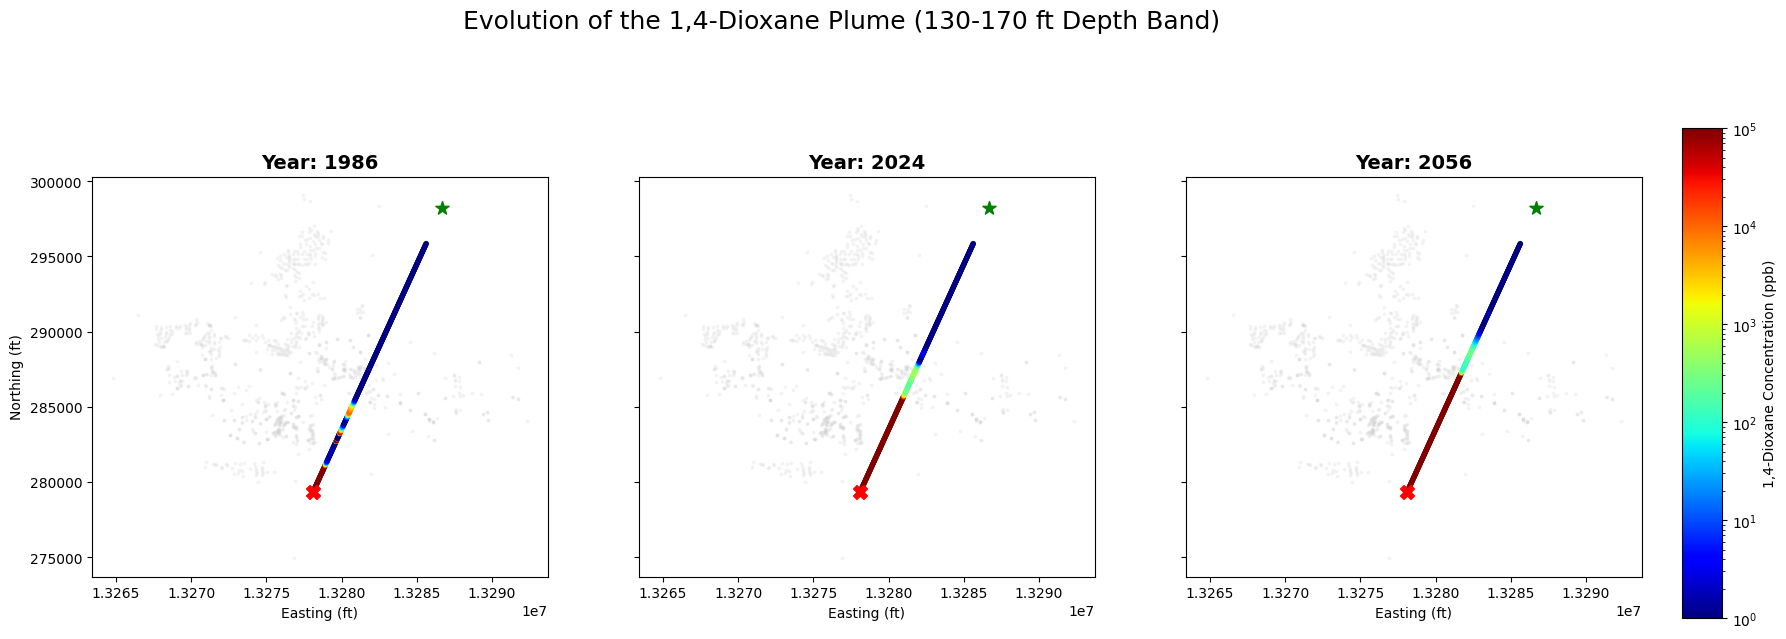

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.colors import LogNorm

# 1. Setup Geographic Mapping Constants
source_coord = np.array([13278097, 279314]) #Gelman source site
target_coord = np.array([13286705, 298215]) # Barton Pond (drinking water inlet)
unit_vec = (target_coord - source_coord) / np.linalg.norm(target_coord - source_coord)


years_to_show = [1986, 2024, 2056]
fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharex=True, sharey=True)
model.eval()

# Iterate through time slices
for i, year in enumerate(years_to_show):
    ax = axes[i]

    # Calculate Normalized Time
    t_val = (year - 1986) / T_MAX_YEARS

    # Generate spatial grid and predictions
    x_grid = torch.linspace(0, 1, 500, device=device).view(-1, 1)
    t_grid = torch.ones_like(x_grid) * t_val

    with torch.no_grad():
        c_norm = model(x_grid, t_grid).cpu().numpy()

    # De-normalize
    c_ppb = 10**(c_norm * C_LOG_MAX) - 1
    x_feet = x_grid.cpu().numpy() * X_MAX_DIST

    # Map to Geographic Coordinates
    geo_x = source_coord[0] + (x_feet * unit_vec[0])
    geo_y = source_coord[1] + (x_feet * unit_vec[1])

    # Plotting Background Wells
    ax.scatter(wells['Easting'], wells['Northing'], c='lightgray', s=3, alpha=0.2)

    # Plot the Forecast Line for that year
    sc = ax.scatter(geo_x, geo_y, c=c_ppb.flatten(), cmap='jet', s=8,
                    norm=LogNorm(vmin=1, vmax=100000))

    # Landmarks
    ax.scatter(*source_coord, color='red', s=100, marker='X', zorder=5)
    ax.scatter(*target_coord, color='green', s=100, marker='*', zorder=5)

    # Formatting
    ax.set_title(f"Year: {year}", fontsize=14, fontweight='bold')
    ax.set_aspect('equal')
    ax.set_xlabel('Easting (ft)')
    if i == 0:
        ax.set_ylabel('Northing (ft)')

# Add a single colorbar for the whole figure
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(sc, cax=cbar_ax, label='1,4-Dioxane Concentration (ppb)')

plt.suptitle('Evolution of the 1,4-Dioxane Plume (130-170 ft Depth Band)', fontsize=18, y=1.02)
plt.show()

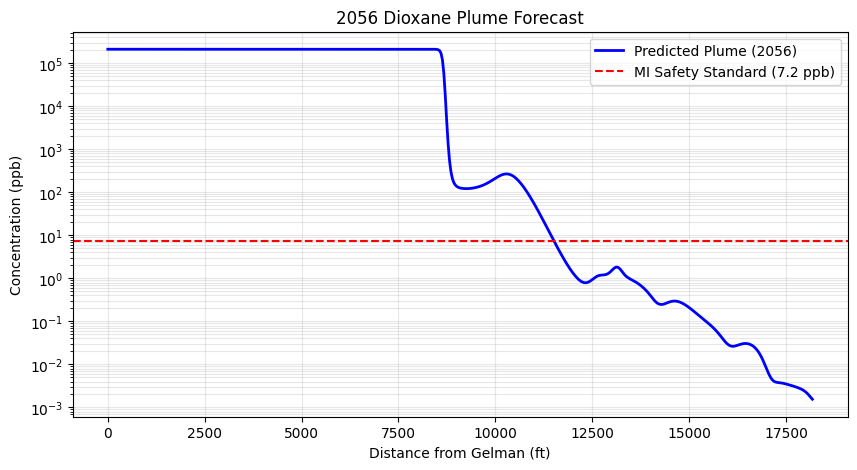

In [13]:
# time_grid and space_grid
x_grid = torch.linspace(0,1,500, device=device).view(-1,1)
t_2056 = torch.ones_like(x_grid)*1.0

with torch.no_grad():
    c_norm = model(x_grid, t_2056).cpu().numpy()

# de-normalizing ***
C_LOG_MAX = np.log10(212000 + 1)
c_ppb = 10**(c_norm * C_LOG_MAX) - 1
x_feet = x_grid.cpu().numpy() * X_MAX_DIST

plt.figure(figsize=(10, 5))
plt.plot(x_feet, c_ppb,label='Predicted Plume (2056)', color='blue', linewidth=2)
plt.axhline(y=7.2, color='red', linestyle='--', label='MI Safety Standard (7.2 ppb)')
plt.yscale('log')
plt.xlabel('Distance from Gelman (ft)')
plt.ylabel('Concentration (ppb)')
plt.title('2056 Dioxane Plume Forecast')
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()

In [11]:
X_NORM_TARGET = 18178.0 / X_MAX_DIST
threshold_norm = np.log10(7.2 + 1) / C_LOG_MAX
impact_year = None

for yr in np.arange(0, 201, 1):
    t_n = torch.tensor([[yr / T_MAX_YEARS]], device=device, dtype=torch.float32)
    with torch.no_grad():
        if model(torch.tensor([[X_NORM_TARGET]], device=device), t_n).item() >= threshold_norm:
            impact_year = 1986 + yr
            break

print(f"=== RESULT: Year of Impact is {impact_year if impact_year else 'Beyond 200 Years'} ===")

=== RESULT: Year of Impact is 2128 ===


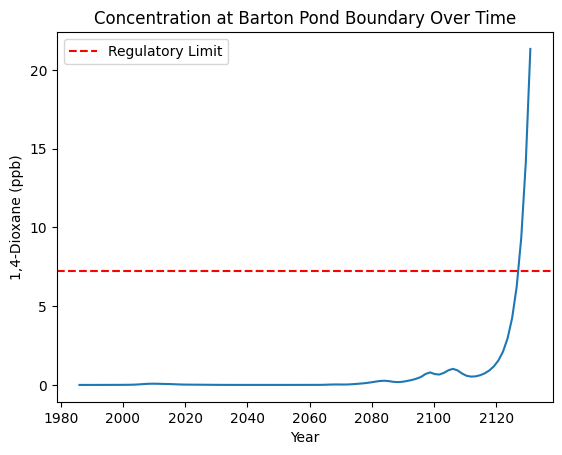

In [25]:
times = np.linspace(0, 145, 100)
concs = []
for t in times:
    with torch.no_grad():
        c = model(torch.tensor([[X_NORM_TARGET]], device=device, dtype = torch.float32), torch.tensor([[t/T_MAX_YEARS]], device=device, dtype=torch.float32)).item()
        concs.append(10**(c * C_LOG_MAX) - 1)

plt.plot(1986 + times, concs)
plt.axhline(7.2, color='r', linestyle='--', label='Regulatory Limit')
plt.title("Concentration at Barton Pond Boundary Over Time")
plt.ylabel("1,4-Dioxane (ppb)"); plt.xlabel("Year"); plt.legend(); plt.show()